Ab Roller Counter

Notes: Use OpenCV and MediaPipe to draw landmarks and connections, this will be based off that push-up counter project.

Make the rep counter valid only to a certain point of view, add instructions for the user to position the streaming device in a certan angle where the body is e.g. sideways to mantain those 2d angles.

Possibly improve to more angles once the initial goal is accomplished.

---

<IPython.core.display.Javascript object>

Saved photo to photo.jpg
Displaying annotated image:


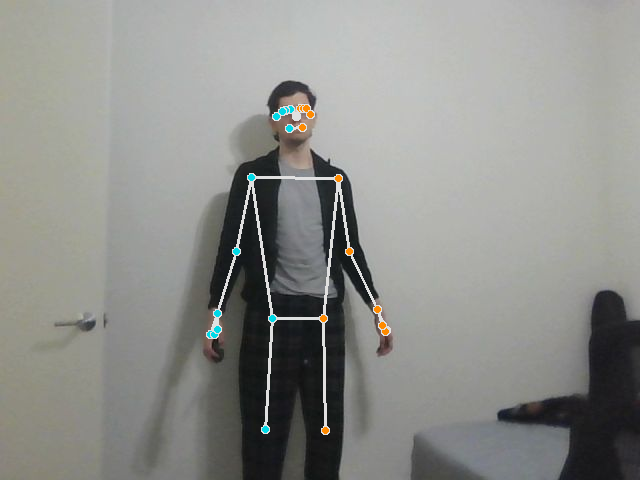

In [9]:
# --- Part 1: Setup and Pose Estimation (Single Image) ---

# necessary libraries
!pip install mediapipe opencv-python matplotlib
# Matplotlib for displaying images in Colab if cv2_imshow has issues

# Import Libraries
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow # Special Colab function for image display
from IPython.display import display, Javascript # webcam access

# Helper function to take a photo from the webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture Photo';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.playsInline = true;
            document.body.appendChild(div);
            div.appendChild(video);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for button to click
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# base64 for decoding the image from JavaScript output
from base64 import b64decode

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# --- main execution for part 1 ---

# Try to take a photo
try:
    image_path = take_photo()
    print(f'Saved photo to {image_path}')

    # Load the captured photo
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image. Please ensure webcam access was granted and photo was taken.")
    else:
        # Convert the BGR image to RGB before processing.
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image and get pose landmarks
        with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            results = pose.process(image_rgb)

            # Draw the pose annotation on the image.
            annotated_image = image.copy() # Make a copy to draw on
            if results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    annotated_image,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            else:
                print("No pose landmarks detected.")

            # Display the annotated image
            print("Displaying annotated image:")
            cv2_imshow(annotated_image) # Use cv2_imshow for Colab
            # If cv2_imshow doesn't work, try matplotlib:
            # plt.figure(figsize=(10, 10))
            # plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.show()

except Exception as err:
    print(str(err))
    print("Could not take photo from webcam. Please ensure you are running this in Google Colab and grant camera permissions.")
    print("As an alternative, you can upload an image manually and process it:")
    # Example for manual image upload (uncomment and run if webcam fails)
    # from google.colab import files
    # uploaded = files.upload()
    # for fn in uploaded.keys():
    #     image_path = fn
    #     break # Process the first uploaded file
    # # Then continue with image loading and processing as above
    # print(f"Processing uploaded image: {image_path}")
    # image = cv2.imread(image_path)
    # # ... (rest of the image processing code)